In [55]:
import pandas as pd

import data_cleaning

#Visualisation
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt

#Sentiment Analysis
import nltk
# nltk.download('vader_lexicon') # einmalig downloaden
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch


In [56]:
pd.reset_option('display.max_rows')
df_imdb = pd.read_json("./data/episodes.json")

# Data Cleaning

## df

In [57]:
df_raw = pd.read_csv("./data/rick_and_morty_master.csv", index_col = "Unnamed: 0")
df_Anton = data_cleaning.clean_data(df_raw)

In [58]:
df = df_Anton #Ändern um zu bestimmen welcher df im weiteren verwendet wird

In [59]:
df["dialouge"] = pd.Series( x.replace("\n", " ").replace("  ", "") for x in df["dialouge"])
df["dialouge"] = df["dialouge"].str.strip()
df["speaker"] = df["speaker"].str.strip(":")

## imdb

In [60]:
df_imdb = df_imdb.transpose()

In [61]:
df = df.assign(season = df.apply(lambda row: df_imdb.iloc[row["episode no."]-1]["season"], axis=1)) #iloc normiert den Zugriff von 0 ausgehend auch wenn der Index im df_imdb mit 1 beginnt

# Data Visualization

In [62]:
# fig = px.bar(df, x="season", y="episode no.")
# fig.show()

# Sentiment Analysis

## Sentiments: negativ, neutral ,positiv, compound

In [63]:
df["dialouge"][0]

'stumbles in drunkenly and turns on the lights morty you got to come on jus you got to come with me'

In [64]:
SentimentAnalyzer = SentimentIntensityAnalyzer()
SentimentAnalyzer.polarity_scores(df["dialouge"][0])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [65]:
# calculate sentiment scores for each line
df_sentiment = pd.DataFrame()
df_sentiment["sentiment"] = df["dialouge"].apply(lambda x: SentimentAnalyzer.polarity_scores(x))

In [66]:
# visualize sentiment scores over time

# set id as column 
df_sentiment['id'] = df_sentiment.index

# set new row as numerical
df_sentiment['neg'] = df_sentiment['sentiment'].apply(lambda x: x['neg'])
df_sentiment['neu'] = df_sentiment['sentiment'].apply(lambda x: x['neu'])
df_sentiment['pos'] = df_sentiment['sentiment'].apply(lambda x: x['pos'])
df_sentiment['compound'] = df_sentiment['sentiment'].apply(lambda x: x['compound'])

In [67]:
df_rolling_average = df_sentiment.drop(columns=["sentiment"]).rolling(10).mean()

In [68]:
# display sentiment for a given season
def display_sentiment_rolling(season:str, windowsize=10)->None:
    df_rolling_average = df_sentiment.drop(columns="sentiment").rolling(windowsize).mean()
    fig = px.line(df_rolling_average.loc[df[df["season"]=="S1"].index], x="id", y=["neg", "neu", "pos"],
        color_discrete_sequence=['rgb(213,94,0)', 'rgb(240,228,66)', 'rgb(0,158,115)'],
        height=300        
    )
    fig.show()

display_sentiment_rolling("S1", 10)

## Sentiment Analysis with emotions

In [69]:
# only need to run if there is no local copy of the model
tokenizer = AutoTokenizer.from_pretrained("michellejieli/emotion_text_classifier")

model = AutoModelForSequenceClassification.from_pretrained("michellejieli/emotion_text_classifier")
model.save_pretrained(".michellejieli/emotion_text_classifier")

In [70]:
def execute_emotion_analysis():
    emotion_analysis = []
    for row in df.iterrows():
        row = row[1]
        text = row["dialouge"]
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = torch.softmax(output.logits, axis=1).detach().numpy()[0]

        emotion_analysis.append({"season": row["season"], "episode": row["episode no."], "dialouge": text, "anger": scores[0], "disgust": scores[1], "fear": scores[2], "joy": scores[3], "neutral": scores[4], "sadness": scores[5], "surprise": scores[6]})

    return emotion_analysis

In [71]:
emotion_analysis = execute_emotion_analysis()
emotion_analysis = pd.DataFrame(emotion_analysis)

In [72]:
df["dialouge"].count() # wichtig für bestimmung von rolling_average; Prozentualer Anteil ~6% für windowssize

np.int64(9618)

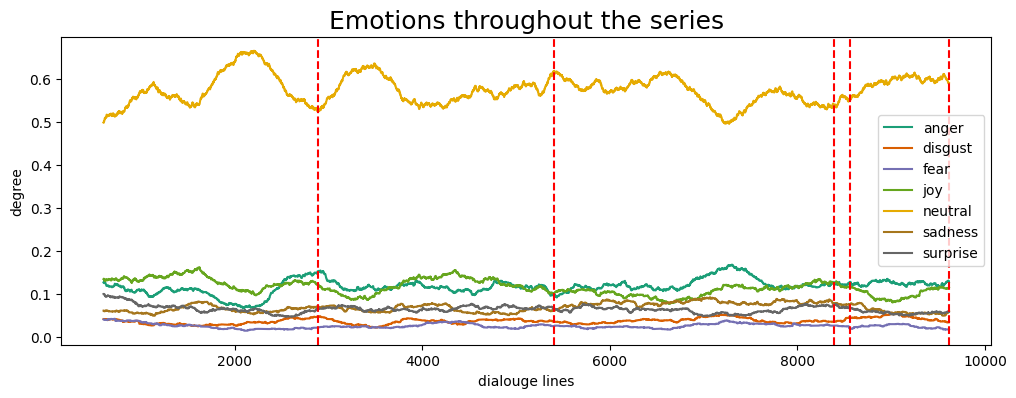

In [73]:
np_season_last_episode = df[["season", "episode no."]].sort_values(by=["season", "episode no."]).drop_duplicates(keep= "last").groupby(by="season", as_index=False).max().to_numpy()
df_trennlinien_pos = df[["season", "episode no."]].sort_values(by=["season", "episode no."]).drop_duplicates(keep= "last").assign(tupel = lambda x: list(zip(x["season"], x["episode no."])))
season_endpoints = df_trennlinien_pos[df_trennlinien_pos["tupel"].isin([tuple(x) for x in np_season_last_episode])].index.to_list()

def display_emotions_series(windowsize=600):
    pd.DataFrame(emotion_analysis)[["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]].rolling(windowsize).mean().plot(cmap="Dark2", figsize=(12,4)); plt.xlabel("dialouge lines"); plt.ylabel("degree"); plt.title("Emotions throughout the series", fontsize=18)

    for endpoint in season_endpoints:
        plt.axvline(x=endpoint, color='red', linestyle='--', linewidth=1.5)

    plt.show()

display_emotions_series()